In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D, Activation, Reshape, add, multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision
import cv2
from sklearn.model_selection import train_test_split
import os

In [2]:
# Paths to your data directories
validation_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/valid'
test_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/test'
train_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/train'

In [3]:
image_size = (224, 224)
batch_size = 50
num_classes = 7

In [4]:
# ImageDataGenerator for training, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)
# Define a function to get images and labels
def get_data_generator(directory, datagen, batch_size, image_size, color_mode, shuffle=True):
    return datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=shuffle
    )
train_generator = get_data_generator(train_data_dir, train_datagen, batch_size, image_size, 'grayscale')
validation_generator = get_data_generator(validation_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale')
test_generator = get_data_generator(test_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale', shuffle=False)

Found 48618 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.


In [5]:
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return 2 * ((precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon()))

In [6]:
def cbam_block(input_tensor, reduction_ratio=16):
    channel_axis = -1
    channel = input_tensor.shape[channel_axis]

# Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(avg_pool)
    avg_pool = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(avg_pool)
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(max_pool)
    max_pool = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(max_pool)

    channel_attention = add([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined_feature = multiply([input_tensor, channel_attention])
# Spatial Attention
    spatial_avg_pool = GlobalAveragePooling2D(keepdims=True)(channel_refined_feature)
    spatial_max_pool = GlobalMaxPooling2D(keepdims=True)(channel_refined_feature)
    concat = concatenate([spatial_avg_pool, spatial_max_pool], axis=-1)
    spatial_attention = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    refined_feature = multiply([channel_refined_feature, spatial_attention])

    return refined_feature

In [8]:
input_img = Input(shape=(224, 224, 1), name='input')

# the 1st block
conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_1')(input_img)
conv1_1 = BatchNormalization()(conv1_1)
conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_2')(conv1_1)
conv1_2 = BatchNormalization()(conv1_2)
cbam1 = cbam_block(conv1_2, reduction_ratio=16)
pool1_1 = MaxPooling2D(pool_size=(2, 2), name='pool1_1')(cbam1)
drop1_1 = Dropout(0.25, name='drop1_1')(pool1_1)

# the 2nd block
conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_1')(drop1_1)
conv2_1 = BatchNormalization()(conv2_1)
conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_2')(conv2_1)
conv2_2 = BatchNormalization()(conv2_2)
conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_3')(conv2_2)
conv2_3 = BatchNormalization()(conv2_3)
cbam2 = cbam_block(conv2_3, reduction_ratio=16)
pool2_1 = MaxPooling2D(pool_size=(2, 2), name='pool2_1')(cbam2)
drop2_1 = Dropout(0.25, name='drop2_1')(pool2_1)

# the 3rd block
conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_1')(drop2_1)
conv3_1 = BatchNormalization()(conv3_1)
conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_2')(conv3_1)
conv3_2 = BatchNormalization()(conv3_2)
conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_3')(conv3_2)
conv3_3 = BatchNormalization()(conv3_3)
conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_4')(conv3_3)
conv3_4 = BatchNormalization()(conv3_4)
cbam3 = cbam_block(conv3_4, reduction_ratio=16)
pool3_1 = MaxPooling2D(pool_size=(2, 2), name='pool3_1')(cbam3)
drop3_1 = Dropout(0.25, name='drop3_1')(pool3_1)

# the 4th block
conv4_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_1')(drop3_1)
conv4_1 = BatchNormalization()(conv4_1)
conv4_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_2')(conv4_1)
conv4_2 = BatchNormalization()(conv4_2)
conv4_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_3')(conv4_2)
conv4_3 = BatchNormalization()(conv4_3)
conv4_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_4')(conv4_3)
conv4_4 = BatchNormalization()(conv4_4)
cbam4 = cbam_block(conv4_4, reduction_ratio=16)
pool4_1 = MaxPooling2D(pool_size=(2, 2), name='pool4_1')(cbam4)
drop4_1 = Dropout(0.25, name='drop4_1')(pool4_1)

# the 5th block
conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_1')(drop4_1)
conv5_1 = BatchNormalization()(conv5_1)
conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_2')(conv5_1)
conv5_2 = BatchNormalization()(conv5_2)
conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_3')(conv5_2)
conv5_3 = BatchNormalization()(conv5_3)
conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_4')(conv5_3)
conv5_4 = BatchNormalization()(conv5_4)
cbam5 = cbam_block(conv5_4, reduction_ratio=16)
pool5_1 = MaxPooling2D(pool_size=(2, 2), name='pool5_1')(cbam5)
drop5_1 = Dropout(0.25, name='drop5_1')(pool5_1)

In [9]:
# Flatten and output
flatten = Flatten(name='flatten')(drop5_1)
output = Dense(num_classes, activation='softmax', name='output')(flatten)

In [10]:
# Implement early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=9, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=9, min_lr=1e-7, verbose=1)

In [11]:
from tensorflow.keras.models import load_model
# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
# Define the model checkpoint callback
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the directory exists

checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoints_epoch_{epoch:02d}.keras")
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,  # Save in 'checkpoints'
    save_weights_only=False,  # Save the complete model
    save_best_only=False,  # Save at every epoch
    save_freq='epoch',  # Save at the end of each epoch
    verbose=1
)
# Check for the latest checkpoint
latest_checkpoint = None
if os.listdir(checkpoint_dir):
    latest_checkpoint = max(
        [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir)],
        key=os.path.getctime
    )
# If a checkpoint exists, load it
if latest_checkpoint:
    print(f"Loading weights from {latest_checkpoint}")
    model = load_model(latest_checkpoint)
else:
    print("No checkpoint found. Initializing a new model.")
    model = Model([input_img], output)
# Define loss and optimizer
loss = "categorical_crossentropy"
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics=["acc", Precision(), Recall()])
model.summary()

No checkpoint found. Initializing a new model.
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.965951 to fit



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_1 (Conv2D)          │ (None, 224, 224, 64)   │            640 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv1_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_2 (Conv2D)          │ (None, 224, 224, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv1_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            256 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 4)        │            256 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1, 64)       │            256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 20,665,799 (78.83 MB)

 Trainable params: 20,654,535 (78.79 MB)

 Non-trainable params: 11,264 (44.00 KB)

In [13]:
# Track training time
start_time = time.time()

# Train the model:
history = model.fit(
    train_generator,
    epochs=50,  
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop, reduce_lr, lr_scheduler, checkpoint_callback]  
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - acc: 0.2463 - loss: 1.8407 - precision: 0.5761 - recall: 0.0194
Epoch 1: saving model to checkpoints/model_checkpoints_epoch_01.keras
973/973 ━━━━━━━━━━━━━━━━━━━━ 649s 610ms/step - acc: 0.2464 - loss: 1.8406 - precision: 0.5762 - recall: 0.0194 - val_acc: 0.4307 - val_loss: 1.4999 - val_precision: 0.7122 - val_recall: 0.1490 - learning_rate: 1.0000e-04
Epoch 2/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - acc: 0.4497 - loss: 1.4363 - precision: 0.6784 - recall: 0.2049
Epoch 2: saving model to checkpoints/model_checkpoints_epoch_02.keras
973/973 ━━━━━━━━━━━━━━━━━━━━ 532s 545ms/step - acc: 0.4497 - loss: 1.4362 - precision: 0.6784 - recall: 0.2050 - val_acc: 0.5664 - val_loss: 1.1684 - val_precision: 0.6727 - val_recall: 0.4321 - learning_rate: 1.0000e-04
Epoch 3/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - acc: 0.5508 - loss: 1.1716 - precision: 0.7204 - recall: 0.3695
Epoch 3: saving model to checkpoints/model_checkpoints_epoch_03.keras

In [14]:
# Print maximum accuracy
max_acc = max(history.history['val_acc'])
print("\n\nMaximum Accuracy Reached Is:", max_acc)



Maximum Accuracy Reached Is: 0.8009523749351501


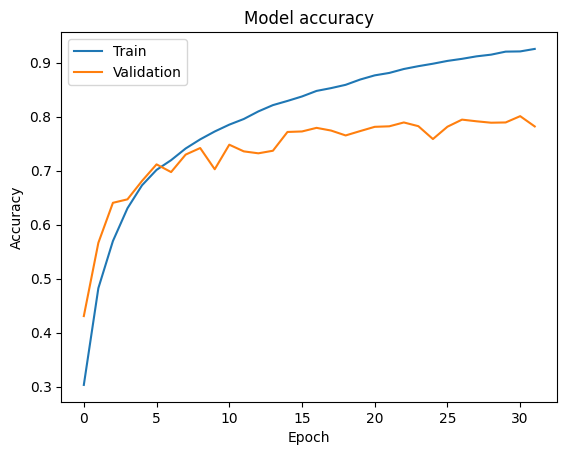

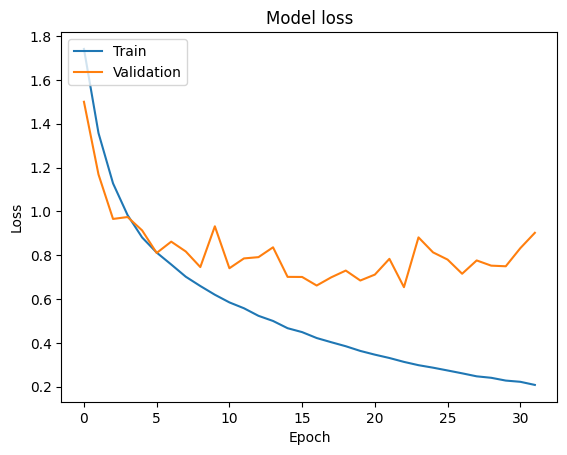

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Evaluate the model on the training data
results = model.evaluate(train_generator, steps=train_generator.samples // batch_size, verbose=2)
print('\nTraining results:', results)

# Unpack individual metrics
train_loss, train_acc, train_precision, train_recall = results
print('\nTraining accuracy:', train_acc)
print('\nTraining precision:', train_precision)
print('\nTraining recall:', train_recall)

# Evaluate the model on the test data
results = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=2)
print('\nTest results:', results)

# Unpack individual metrics
val_loss, val_acc, val_precision, val_recall = results
print('\nValidation accuracy:', val_acc)
print('\nValidation precision:', val_precision)
print('\nValidation recall:', val_recall)

972/972 - 266s - 273ms/step - acc: 0.8917 - loss: 0.3016 - precision: 0.9132 - recall: 0.8708

Training results: [0.3015696704387665, 0.8916872143745422, 0.9131513833999634, 0.8707818984985352]

Training accuracy: 0.8916872143745422

Training precision: 0.9131513833999634

Training recall: 0.8707818984985352
84/84 - 31s - 375ms/step - acc: 0.7705 - loss: 0.7170 - precision: 0.7956 - recall: 0.7479

Test results: [0.717037558555603, 0.7704761624336243, 0.795592725276947, 0.7478571534156799]

Validation accuracy: 0.7704761624336243

Validation precision: 0.795592725276947

Validation recall: 0.7478571534156799


84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step


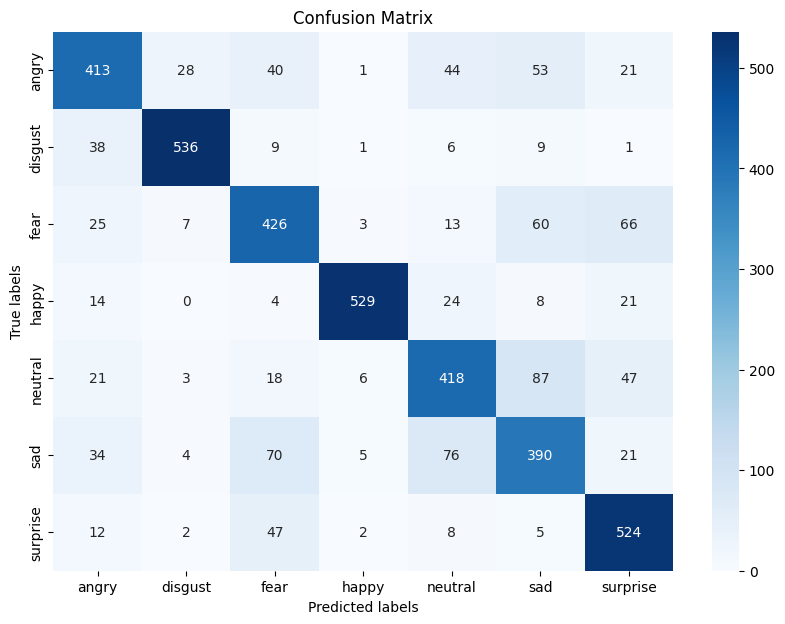

              precision    recall  f1-score   support

       angry       0.74      0.69      0.71       600
     disgust       0.92      0.89      0.91       600
        fear       0.69      0.71      0.70       600
       happy       0.97      0.88      0.92       600
     neutral       0.71      0.70      0.70       600
         sad       0.64      0.65      0.64       600
    surprise       0.75      0.87      0.81       600

    accuracy                           0.77      4200
   macro avg       0.77      0.77      0.77      4200
weighted avg       0.77      0.77      0.77      4200



In [17]:
# Predict classes for test set
test_generator.reset()  # Reset the generator to avoid any state issues
Y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Ensure the ground truth labels also cover all samples
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

In [18]:
# Classification Report
print(classification_report(test_generator.classes, y_pred, target_names=train_generator.class_indices.keys()))

# Tabulate cost efficiency information including accuracy and validation accuracy for each epoch
epochs = len(history.history['acc'])
cost_efficiency_data = {
    "Epoch": list(range(1, epochs + 1)),
    "Training Accuracy": history.history['acc'],
    "Validation Accuracy": history.history['val_acc']
}
cost_efficiency_df = pd.DataFrame(cost_efficiency_data)
print(cost_efficiency_df)

# Summary of overall cost efficiency
summary_data = {
    "Metric": ["Training Time (seconds)", "Final Validation Accuracy", "Final Training Accuracy", "Training Accuracy", "Test Accuracy"],
    "Value": [training_time, history.history['val_acc'][-1], history.history['acc'][-1], train_acc, val_acc]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

              precision    recall  f1-score   support

       angry       0.74      0.69      0.71       600
     disgust       0.92      0.89      0.91       600
        fear       0.69      0.71      0.70       600
       happy       0.97      0.88      0.92       600
     neutral       0.71      0.70      0.70       600
         sad       0.64      0.65      0.64       600
    surprise       0.75      0.87      0.81       600

    accuracy                           0.77      4200
   macro avg       0.77      0.77      0.77      4200
weighted avg       0.77      0.77      0.77      4200

    Epoch  Training Accuracy  Validation Accuracy
0       1           0.303221             0.430714
1       2           0.482476             0.566429
2       3           0.569645             0.640476
3       4           0.630343             0.646905
4       5           0.672878             0.680952
5       6           0.701448             0.711667
6       7           0.719445             0.697381
7  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


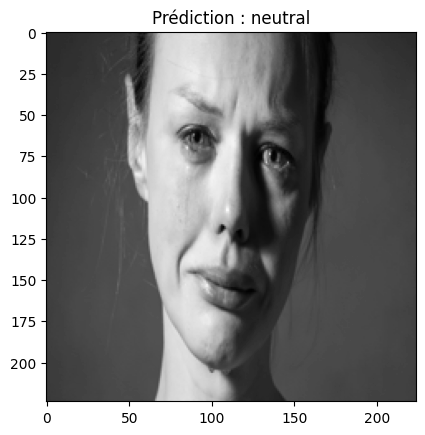

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


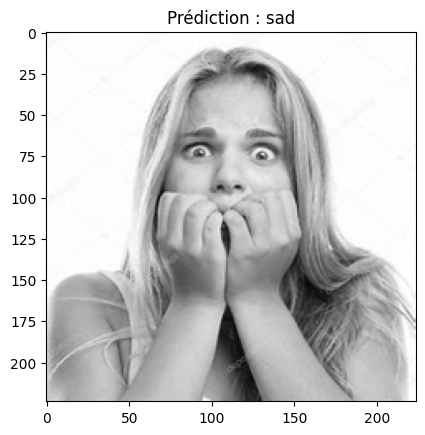

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


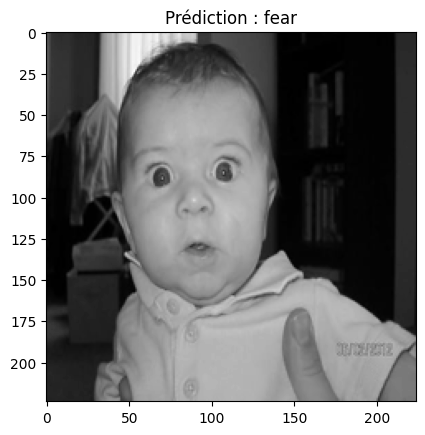

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


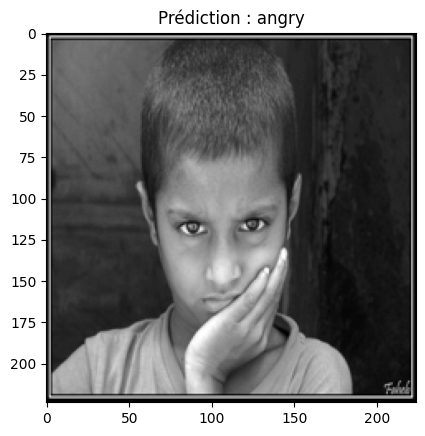

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


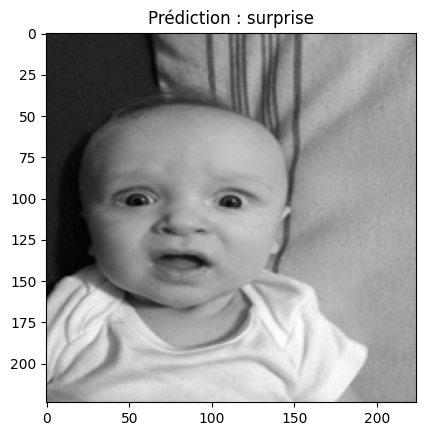

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


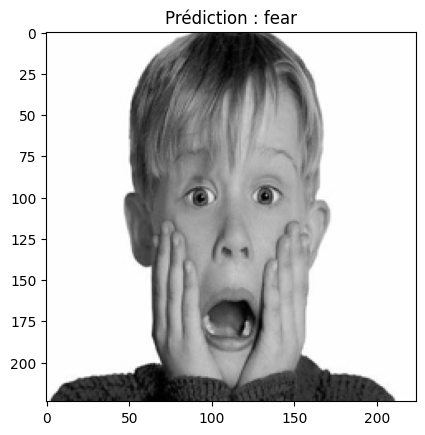

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


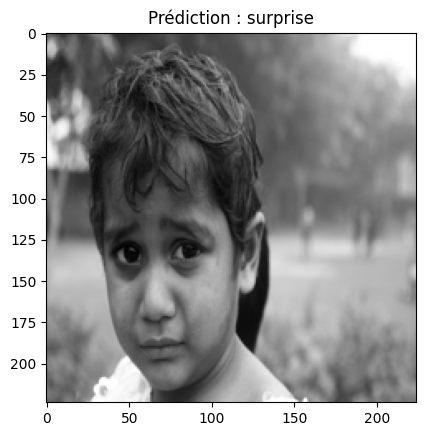

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


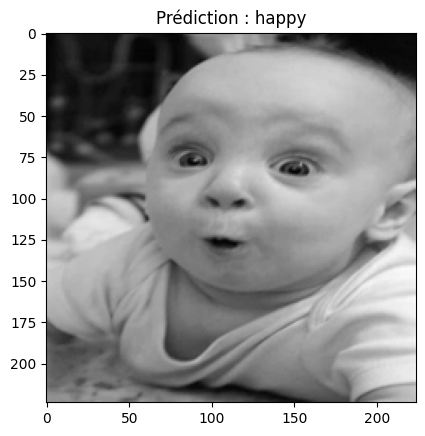

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


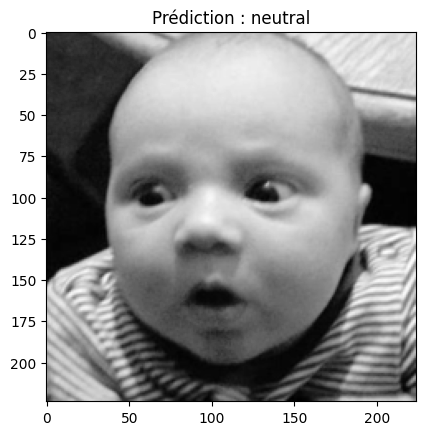

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


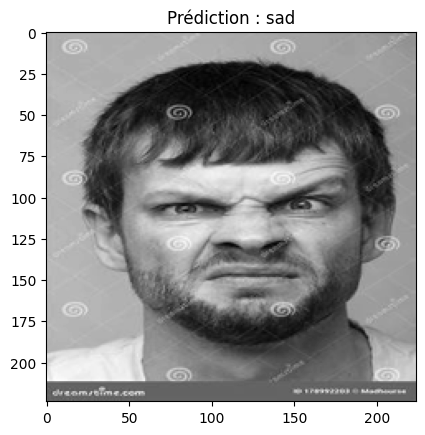

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


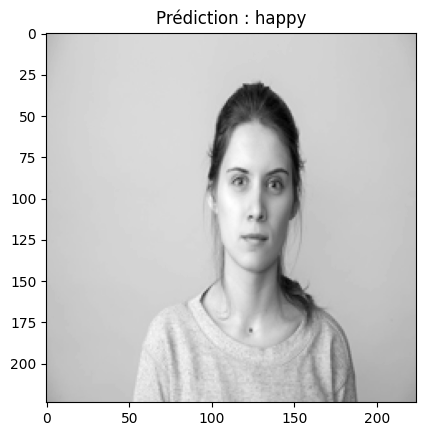

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


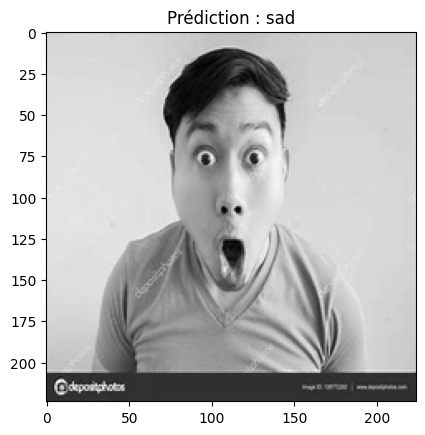

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


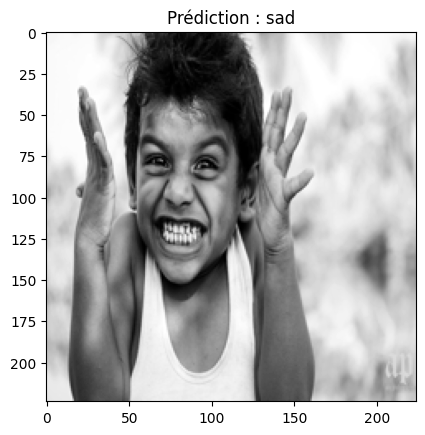

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


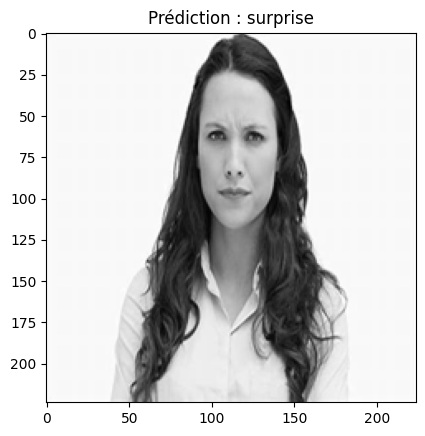

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


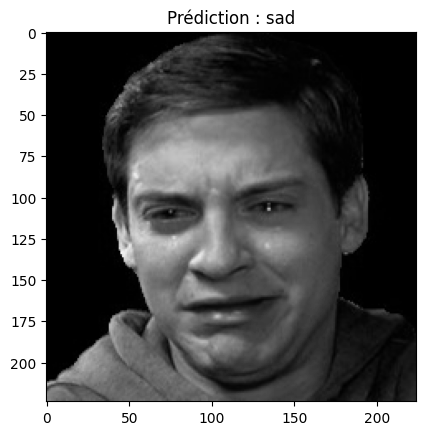

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


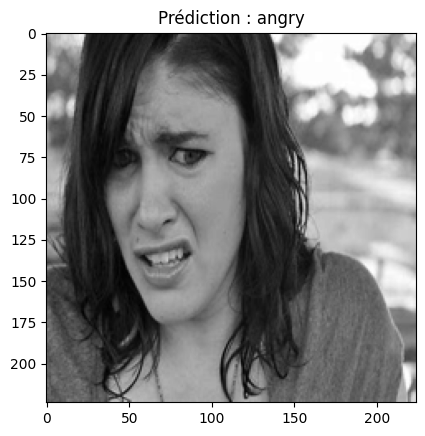

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


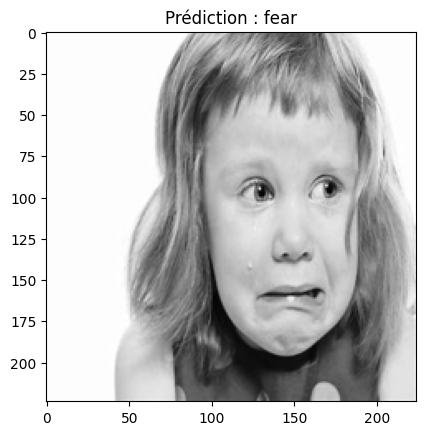

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


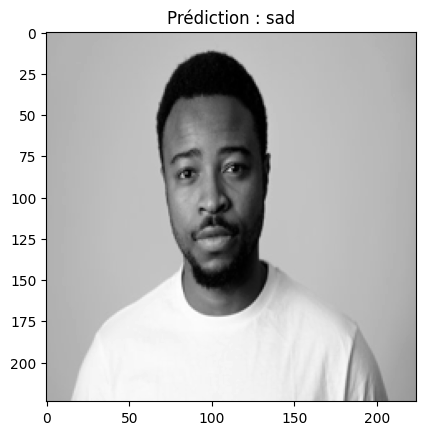

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Obtenir les classes du générateur
class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}  # Mapping inverse

# Dossier contenant les images à tester
images_folder = '/kaggle/input/testemotion/'  

# Charger et traiter toutes les images du dossier
image_files = [f for f in os.listdir(images_folder) if f.endswith(('jpeg', 'png', 'jpg'))]  # Filtrer les fichiers d'image
# Parcourir chaque image
for img_file in image_files:
    img_path = os.path.join(images_folder, img_file)
    
    # Charger et prétraiter l'image
    img = Image.open(img_path).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner
    img_array = np.array(img) / 255.0  # Normaliser les valeurs des pixels
    img_array = np.expand_dims(img_array, axis=-1)  # Ajouter la dimension de canal
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension de batch

    # Faire une prédiction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Obtenir l'indice de la probabilité maximale
    predicted_label = label_map[predicted_class]  # Mapper l'indice au nom de la classe

    # Afficher l'image et la prédiction
    plt.imshow(img, cmap='gray')
    plt.title(f"Prédiction : {predicted_label}")  # Afficher l'étiquette de la classe
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


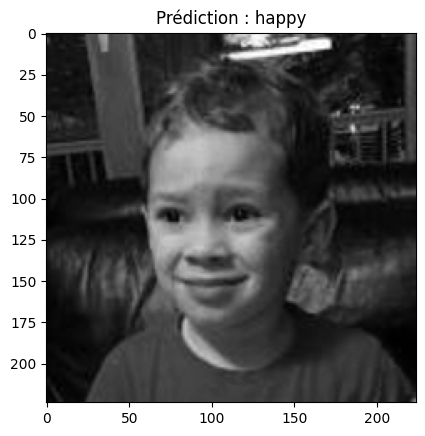

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


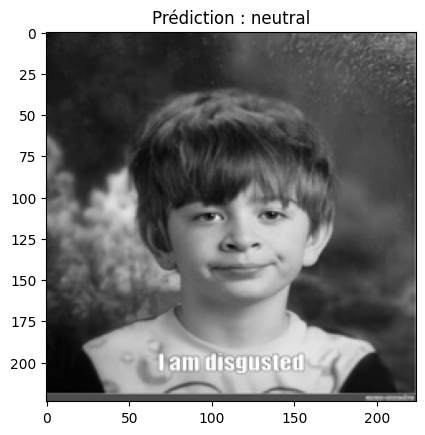

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


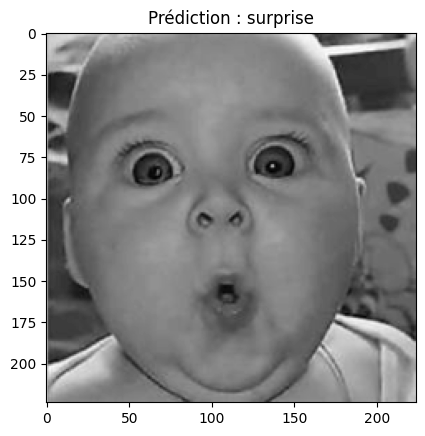

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


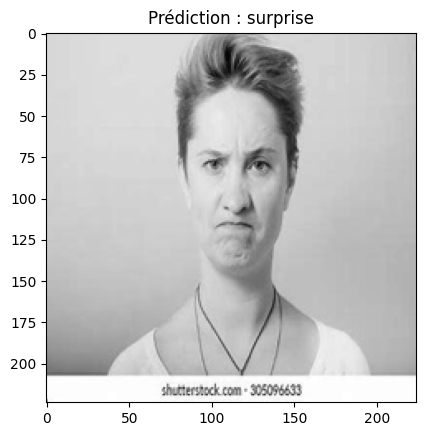

In [28]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Obtenir les classes du générateur
class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}  # Mapping inverse

# Dossier contenant les images à tester
images_folder = '/kaggle/input/testemotion1'  

# Charger et traiter toutes les images du dossier
image_files = [f for f in os.listdir(images_folder) if f.endswith(('jpeg', 'png', 'jpg'))]  # Filtrer les fichiers d'image
# Parcourir chaque image
for img_file in image_files:
    img_path = os.path.join(images_folder, img_file)
# Charger et prétraiter l'image
    img = Image.open(img_path).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner
    img_array = np.array(img) / 255.0  # Normaliser les valeurs des pixels
    img_array = np.expand_dims(img_array, axis=-1)  # Ajouter la dimension de canal
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension de batch

    # Faire une prédiction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Obtenir l'indice de la probabilité maximale
    predicted_label = label_map[predicted_class]  # Mapper l'indice au nom de la classe

    # Afficher l'image et la prédiction
    plt.imshow(img, cmap='gray')
    plt.title(f"Prédiction : {predicted_label}")  # Afficher l'étiquette de la classe
    plt.show()
    

In [32]:
# Define the path to save the model with a valid extension
model_save_path = '/kaggle/working/saved_model.keras'

# Save the model
model.save(model_save_path)
print(f"Model saved successfully at {model_save_path}")


Model saved successfully at /kaggle/working/saved_model.keras
